# Experiment 5

In [25]:
import time

import pandas as pd
import numpy as np

import quantstats as qs

from tinycta.portfolio import build_portfolio
from tinycta.linalg import *
from tinycta.signal import *

In [25]:
#from datetime import datetime
#custom_date_parser = lambda x: datetime.strptime(x, "%d.%m.%Y")
#df = pd.read_csv('data/futures_prices.csv',
#                 parse_dates=[0],
#                date_parser=custom_date_parser, index_col=0)

#df.columns = {str(abs(hash(column))) for column in df.columns}
#df.to_csv('data/p_hashed.csv')

In [26]:
# Load prices
prices = pd.read_csv("data/p_hashed.csv", index_col=0, parse_dates=True).ffill().truncate(before="1970-01-01")

In [27]:
from ipywidgets import Label, HBox, VBox, IntSlider, FloatSlider

fast = IntSlider(min=4, max=192, step=4, value=32)
slow = IntSlider(min=4, max=192, step=4, value=96)
vola = IntSlider(min=4, max=192, step=4, value=32)
winsor = FloatSlider(min=1.0, max=6.0, step=0.1, value=4.2)
corr = IntSlider(min=50, max=500, step=10, value=200)
shrinkage = FloatSlider(min=0.0, max=1.0, step=0.05, value=0.5)
left_box = VBox([Label("Fast Moving Average"), 
                 Label("Slow Moving Average"), 
                 Label("Volatility"), 
                 Label("Winsorizing"),
                 Label("Correlation"),
                 Label("Shrinkage")])

right_box = VBox([fast, slow, vola, winsor, corr, shrinkage])
HBox([left_box, right_box])

In [28]:
T = time.time()
correlation = corr.value

# this is a lot faster than Pandas...
position = np.nan*np.zeros_like(prices.values)

returns_adj = prices.apply(returns_adjust, com=vola.value, clip=winsor.value)
# DCC by Engle
cor = returns_adj.ewm(com=corr.value, min_periods=corr.value).corr()

mu = np.tanh(returns_adj.cumsum().apply(osc)).values
vo = prices.pct_change().ewm(com=vola.value, min_periods=vola.value).std().values

for n,t in enumerate(prices.index):
    matrix = shrink2id(cor.loc[t].values, lamb=shrinkage.value)
    risk_position = solve(matrix, mu[n])/inv_a_norm(mu[n], matrix)
    position[n] = risk_position/vo[n]

portfolio = build_portfolio(prices, pd.DataFrame(index=prices.index, columns=prices.keys(), data=position))
print(time.time()-T)


/home/thomas/.pyenv/versions/3.10.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


9.086904048919678


                    Strategy
------------------  ----------
Start Period        1990-01-02
End Period          2023-04-14
Risk-Free Rate      0.0%
Time in Market      94.0%

Cumulative Return   117.57%
CAGR﹪              2.36%

Sharpe              1.2
Prob. Sharpe Ratio  100.0%
Sortino             1.75
Sortino/√2          1.24
Omega               1.23

Max Drawdown        -3.04%
Longest DD Days     583

Gain/Pain Ratio     0.23
Gain/Pain (1M)      1.45

Payoff Ratio        1.01
Profit Factor       1.23
Common Sense Ratio  1.28
CPC Index           0.68
Tail Ratio          1.04
Outlier Win Ratio   3.44
Outlier Loss Ratio  3.34

MTD                 0.18%
3M                  0.68%
6M                  0.32%
YTD                 0.81%
1Y                  2.4%
3Y (ann.)           1.84%
5Y (ann.)           1.13%
10Y (ann.)          1.69%
All-time (ann.)     2.36%

Avg. Drawdown       -0.37%
Avg. Drawdown Days  27
Recovery Factor     38.73
Ulcer Index         0.01
Serenity Index      8.46


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


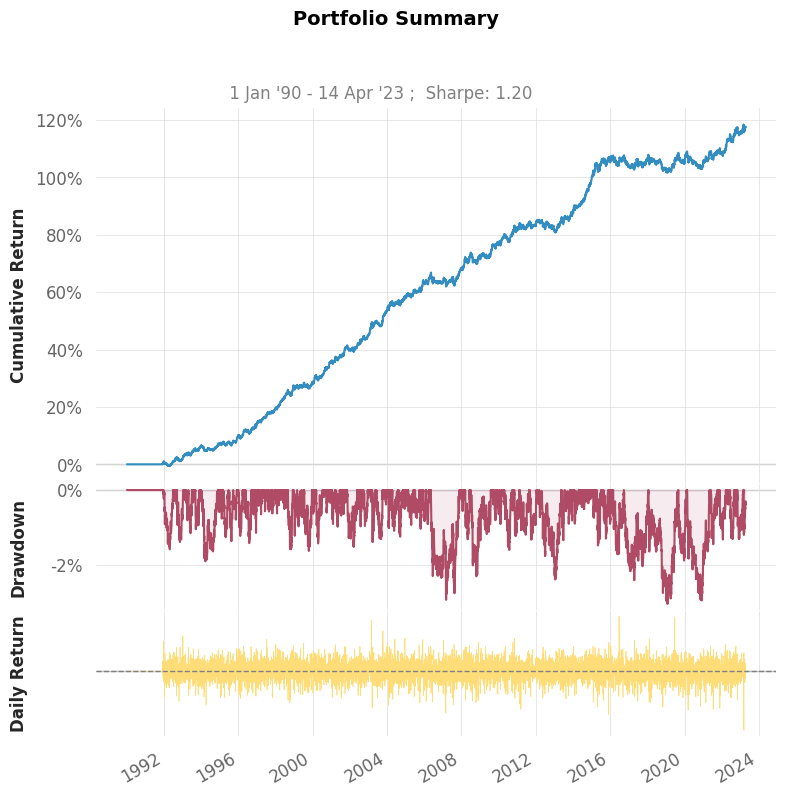

/home/thomas/.pyenv/versions/3.10.10/lib/python3.10/site-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


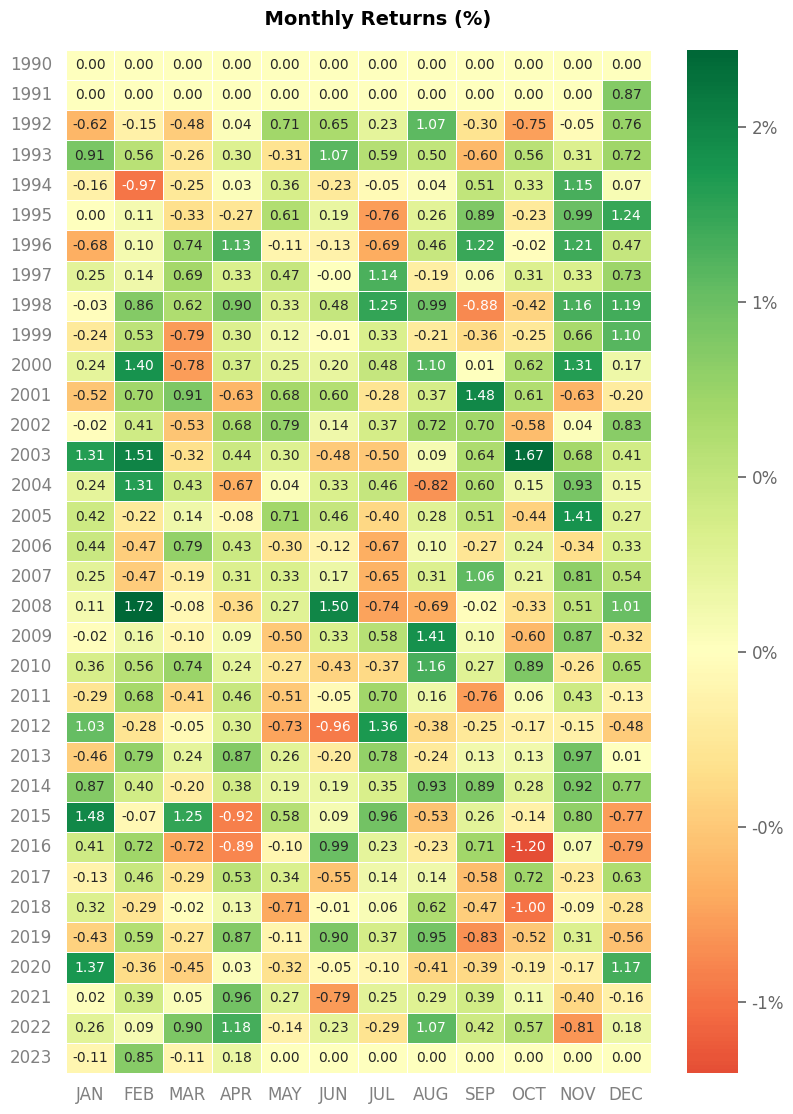

In [29]:
qs.reports.basic(portfolio.returns(init_capital=1000))

# Conclusions
* Dramatic relativ improvements observable despite using the same signals as in previous Experiment.
* Main difference here is to take advantage of cross-correlations in the risk measurement.
* Possible to add constraints on individual assets or groups of them.
* Possible to reflect trading costs in objective with regularization terms (Ridge, Lars, Elastic Nets, ...)

In [31]:
r=portfolio.returns(init_capital=1000)

In [32]:
r

1990-01-02    0.000000
1990-01-03    0.000000
1990-01-04    0.000000
1990-01-05    0.000000
1990-01-08    0.000000
                ...   
2023-04-10   -0.000244
2023-04-11    0.001072
2023-04-12    0.000267
2023-04-13    0.000656
2023-04-14   -0.000961
Length: 8684, dtype: float64

In [34]:
16*r.mean()/r.std()

1.208851488221794